# An Analysis of Magic: The Gathering's Creatures
Welcome to Magic: The Gathering, a trading card game produced by Wizards of the Coast where each player pretends to be a wizard casting spells and summoning creatures to reduce their opponent's life points from 20 to 0. This game has been out since 1993, and has changed dramatically since then, with the game increasing in power level and complexity over its 30 years of existence. 

## Vocabulary
Throughout the analysis I will use several Magic: the Gathering specific terms. While it is not necessary to have played magic to understand this analysis, the following definition will certainly be helpful. 

  1. Mana: The elemental magic used to cast spells, which is generated from land cards. Each card has its own mana cost, which denotes the amount and type of mana that it requires. There are five types of mana: green (G), white (W), black (B), blue (U), and red (R), each with their own types of spells they like to cast. "CMC" refers to "Converted Mana Cost", or how much total mana it costs to cast the spell.
  2. Set: Magic cards are released periodically in groups called "sets" which contain a few hundred magic cards each.
  3. Type: Each card has a different type; for the purpose of this analysis, we will be focusing on creatures.
  4. Creature: Creatures represent minions you can summon to help you fight your opponent. Each creature has a mana cost, a power (its strength), a toughness (its health), a few types (like Human, Elf, Dragon, etc.), and its abilities. A creature with power X and toughness Y is called as "an X/Y creature".
  5. Keyword: Some abilities of creatures are common enough across sets that they get their own keyword. This is just an easy way for players to denote some abilities.
  6. Ability: Most creatures (not all!) have abilities that can be activated or are always in effect. Some creatures have no abilities, which are called vanilla creatures; some creatures only have keyworded abilities, which are called "french vanilla" creatures.

Here we import all necessary modules for the project.

In [24]:
import pandas as pd
import json
import requests
import matplotlib.pyplot as plt
import re
import numpy as np
import datetime as dt
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

## Data Cleaning

The data we will use is from [scryfall](https://scryfall.com/), a community-ran magic the gathering site. Scryfall's data is often more reliable and accurate than the data that Wizards produces, and it is also freely available for download through their API. This data contains every single card in Magic's history that was printed in English - 78,242 card objects. However, many of these objects are extraneous and would hurt our data analysis. For the next section, I will prune down these cards to exclude reprinted cards, illegal cards, joke cards, and many other types of cards that have been created over the years.

In [2]:
URL = "https://data.scryfall.io/default-cards/default-cards-20221212220657.json"
full_scryfall_df = pd.DataFrame(json.loads(requests.get(URL).text))
full_scryfall_df.head()

,object,id,oracle_id,multiverse_ids,mtgo_id,mtgo_foil_id,tcgplayer_id,cardmarket_id,name,lang,...,tcgplayer_etched_id,attraction_lights,color_indicator,life_modifier,hand_modifier,printed_type_line,printed_text,content_warning,flavor_name,variation_of
0,card,0000579f-7b35-4ed3-b44c-db2a538066fe,44623693-51d6-49ad-8cd7-140505caf02f,[109722],25527.0,25528.0,14240.0,13850.0,Fury Sliver,en,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,card,00006596-1166-4a79-8443-ca9f82e6db4e,8ae3562f-28b7-4462-96ed-be0cf7052ccc,[189637],34586.0,34587.0,33347.0,21851.0,Kor Outfitter,en,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,card,0000a54c-a511-4925-92dc-01b937f9afad,dc4e2134-f0c2-49aa-9ea3-ebf83af1445c,[],NaN,NaN,98659.0,NaN,Spirit,en,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,card,0000cd57-91fe-411f-b798-646e965eec37,9f0d82ae-38bf-45d8-8cda-982b6ead1d72,[435231],65170.0,65171.0,145764.0,301766.0,Siren Lookout,en,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,card,00012bd8-ed68-4978-a22d-f450c8a6e048,5aa12aff-db3c-4be5-822b-3afdf536b33e,[1278],NaN,NaN,1623.0,5664.0,Web,en,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


This dataframe also comes with 84 columns, many of which we do not need. I will remove all columns except for the useful ones in determining a card's qualities, and in determining whether we want to analyze the card or not.

In [3]:
df = full_scryfall_df[['name',                       # the name of the card - not technically necessary but helpful for debugging
                       'mana_cost',                  # what type of mana the card costs to summon
                       'cmc',                        # how much mana the card costs
                       'type_line',                  # the type of the card (creature, sorcery, etc)
                       'oracle_text',                # what the card does
                       'power', 'toughness',         # the strength of the card if it's a creature
                       'colors', 'color_identity',   # more info on what type of mana the card costs
                       'keywords',                   # the keywords on the card (more on this later)
                       'set', 'released_at',         # when the card was released
                       'rarity',                     # how much the card was printed
                       'games',                      # games tells if it is legal online or in paper (we exclude online-only cards)
                       'legalities']]                # which formats the card is legal in

First, we will remove all cards that are in there multiple times (e.g. they were printed in multiple sets). Wizards does this sometimes to bring back fan favorite cards or to have some basic cards that always work well. 

In [4]:
df = df.sort_values(by=['released_at', 'name'])
df = df.drop_duplicates(subset=['name'])

Next, we will remove online-only cards. Wizards of the Coast released a program called Magic Arena, and to promote it they released cards that were only legal for that program. However, these cards were not created with the balance of the paper format in mind, and reference random effects and things only possible online. Therefore, I am excluding them from this analysis.

In [5]:
df = df[df['games'].apply(lambda i: 'paper' in i)]

Some cards are illegal to play for power-level reasons (too strong for the format); however, we can still analyze these. The "not legal" designation means cards that are literally unplayable: they are printed alongside magic cards, but just say promotional text or act as other game pieces. Tokens are one such piece; some cards create tokens, but you can't put the actual token cards in your deck. However, Scryfall treats all of these as "card objects" and puts them in.

In [6]:
def legal(legalities):
    v = legalities.values()
    if len(set(v)) == 1 and "not_legal" in v:
        return False
    return True

df = df[df['legalities'].apply(legal)]
df = df[~df["type_line"].str.contains("Token", na=False)] # remove tokens

Finally, some cards were designed as jokes by the Wizards designers in sets called "unsets". These cards, like the online cards, aren't tuned for interacting with any other cards, and so I will exclude them from this dataset.

In [7]:
unsets = ['unglued', 'unhinged', 'unstable', 'unsanctioned', 'unfinity']
sets = json.loads(requests.get("https://api.scryfall.com/sets").text)
for s in sets["data"]:
    if s['name'].lower() in unsets:
        df = df[~df["set"].str.contains(s['code'])]

## Data Processing

Some of these columns aren't qute in the format we'd like them to be in, so I'm going to change them to be friendlier to numerical algorithms, and add some useful columns. 

The actual release date isn't particularly mathematically helpful, so I will change it to the number of years since the first set (known as Alpha) was released, on August 5th 1993. 

In [8]:
df = df.dropna() # drop NAN values

alpha_release_date = dt.datetime(1993, 8, 5)
df['released_at'] = df['released_at'].apply(lambda i: (dt.datetime.strptime(i, '%Y-%m-%d').year - alpha_release_date.year))

One helpful factor in our analysis will show how deep into a color a card is. Wizards often makes cards cost more mana of a certain color if they want to nerf the card somewhat; e.g. if they want to make a more powerful creature at the same mana cost. So, counting the amount of colored mana required to cast the spell will be a useful factor in the analysis. A similar factor is the number of different colors: a spell that requires multiple types of mana is considered more difficult to cast, and so may have a lower mana cost.

In [9]:
df["num_colored_pips"] = df["mana_cost"].apply(lambda mana_cost: len(re.findall("\{[^\d]\}", str(mana_cost))))
df["num_colors"] = df["colors"].apply(len)

Finally, for this analysis we will just be looking at creatures. Let's also make those CMC, power, and toughness values integers to be easier to work with. If they aren't underlylingly integers (some have X, \*, or ?, or nothing), we wil ignore those as they are difficult to work with without also parsing the ability text.

In [10]:
df = df[df["type_line"].str.contains("Creature", na=False)]

def make_int(i):
    try:
        return int(i)
    except ValueError:
        return np.nan

for i in ['cmc', 'power', 'toughness']:
    df[i] = df[i].apply(make_int).astype('Int64')#
df = df.dropna()

Let's take a look!

As you can see, we've now got the important parts of a card, and the cards are sorted conveniently by their release date. We are now looking at the first magic cards ever released. How strong were they? Let's find out!

## Vanilla Creature Analysis
A vanilla creature is a creature with no text whatsoever - just stats! The "classic" vanilla creature is the Grizzly Bears, a 2/2 for 2 mana in green.

In [11]:
df[df["name"].str.contains("Grizzly Bears")]

,name,mana_cost,cmc,type_line,oracle_text,power,toughness,colors,color_identity,keywords,set,released_at,rarity,games,legalities,num_colored_pips,num_colors
63158,Grizzly Bears,{1}{G},2,Creature — Bear,,2,2,[G],[G],[],lea,0,common,[paper],"{'standard': 'not_legal', 'future': 'not_legal...",1,1


However, not all creatures are created equally. For example, the Coral Eel has the same mana cost, but only 1 toughness. The difference? It's in blue!

In [12]:
df[df["name"].str.contains("Coral Eel")]

,name,mana_cost,cmc,type_line,oracle_text,power,toughness,colors,color_identity,keywords,set,released_at,rarity,games,legalities,num_colored_pips,num_colors
16522,Coral Eel,{1}{U},2,Creature — Fish,,2,1,[U],[U],[],por,4,common,[paper],"{'standard': 'not_legal', 'future': 'not_legal...",1,1


Clearly, some colors are better at producing creatures than other colors. But how much better? Let's start with vanilla creatures, since we know none of their abilities is influencing their mana cost. Therefore, we can just get a look at how much each point of power and toughness is costing, mana-wise.

In [13]:
vanilla_df = df[df["oracle_text"] == ""]
vanilla_df.head()

,name,mana_cost,cmc,type_line,oracle_text,power,toughness,colors,color_identity,keywords,set,released_at,rarity,games,legalities,num_colored_pips,num_colors
58740,Craw Wurm,{4}{G}{G},6,Creature — Wurm,,6,4,[G],[G],[],lea,0,common,[paper],"{'standard': 'not_legal', 'future': 'not_legal...",2,1
54563,Earth Elemental,{3}{R}{R},5,Creature — Elemental,,4,5,[R],[R],[],lea,0,uncommon,[paper],"{'standard': 'not_legal', 'future': 'not_legal...",2,1
66828,Fire Elemental,{3}{R}{R},5,Creature — Elemental,,5,4,[R],[R],[],lea,0,uncommon,[paper],"{'standard': 'not_legal', 'future': 'not_legal...",2,1
35350,Gray Ogre,{2}{R},3,Creature — Ogre,,2,2,[R],[R],[],lea,0,common,[paper],"{'standard': 'not_legal', 'future': 'not_legal...",1,1
63158,Grizzly Bears,{1}{G},2,Creature — Bear,,2,2,[G],[G],[],lea,0,common,[paper],"{'standard': 'not_legal', 'future': 'not_legal...",1,1


Only 2.57% of creatures ever printed have been vanilla, so this analysis won't tell us much about a lot of creatures. However, it gives us a base from which to peform similar analyses on more complicated creatures.

In [14]:
len(vanilla_df.index) / len(df.index)

0.02571632669259465

Now we can look at plots of mana cost, power, and toughness. We can see from this plot that the vast majority of vanilla creatures are very small, with less than 4 power and toughness. Generally, when a creature has larger power and toughness, it is a more powerful creature in the Magic storyline, and the designers want to make the card more exciting. So, they give it abilities, which means it doesn't show up in this plot.

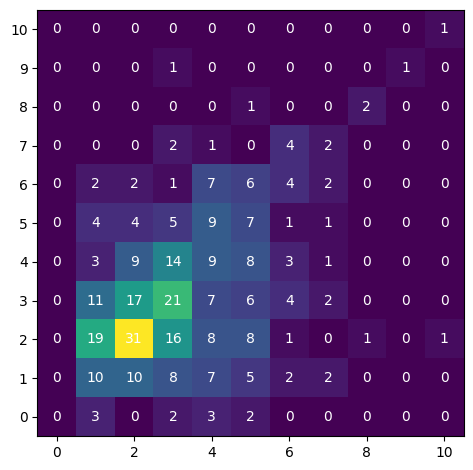

In [15]:
mp, mt = max(vanilla_df['power']) + 1, max(vanilla_df['toughness']) + 1
data = np.zeros((mp, mt))

fig, ax = plt.subplots()

for power in range(mp):
    for toughness in range(mt):
        count = len(vanilla_df[(vanilla_df['power'] == power) & (vanilla_df['toughness'] == toughness)]['cmc'].values)
        data[mp - power - 1][toughness] = count
        
        text = ax.text(toughness, mp - power - 1, count,
                       ha="center", va="center", color="w")

ax.set_yticks(np.arange(mp), labels=list(range(mp))[::-1]) # invert power so that 0/0 is the bottom left corner

im = ax.imshow(data)
fig.tight_layout()
plt.show()

Now let's try to predict the mana cost of the creature based on the data we have. First, let's drop all unnecessary data and get just the good stuff into a `data_df`. This will contain all the variables with which we will predict Converted Mana Cost.

Our goal is to predict the Converted Mana Cost of a creature based just on its vanilla stats. These stats include its power, toughness, color, rarity, release date, number of colored pips, and number of colors. My predictions are as follows:

 1. A point of power will cost more than a point of toughness, as there are many cheap creatures such as Walls which are good at defending but poor at attacking.
 2. The color will have some influence; Green creatures will be the cheapest, and probably Blue creatures will incur some mana cost penalty, but I'm not sure where the other colors will be in between.
 3. Rarity will have a large influence, especially on vanilla creatures; rare vanilla creatures will be much less expensive than common ones. 
 4. Release date will have some influence, as newer cards are generally considered more powerful than older cards.
 5. Number of colored pips and number of colors may not matter much for vanilla creatures as most vanilla creatures are one color and very low colored pips. However, they might come up with a bigger effect in later analyses.

In [16]:
data_df = vanilla_df.drop(columns=["name", "mana_cost", "type_line", "oracle_text", "color_identity", "keywords", "set", "games", "legalities"])
data_df.head()

,cmc,power,toughness,colors,released_at,rarity,num_colored_pips,num_colors
58740,6,6,4,[G],0,common,2,1
54563,5,4,5,[R],0,uncommon,2,1
66828,5,5,4,[R],0,uncommon,2,1
35350,3,2,2,[R],0,common,1,1
63158,2,2,2,[G],0,common,1,1


We still have some categorical variables. A linear regression cannot handle these, so I wrote a custom function that will expand them and then one-hot encode them. One-hot encoding means that instead of having a single rarity column with values "common" and "uncommon", we now have two rarity columns, "rarity_common" and "rarity_uncommon", which contain integer values which are 0 if the card is rare and 1 if the card is uncommon. We will do the same thing for colors -- note that a card can have multiple colors, so there could be multiple `colors_` columns that have a 1 in them for a given card.

To learn more about one-hot encoding, visit [this link](https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/). 

This will give us a total of 11 variables for our regression.

In [17]:
def dummy_list(data_df, one_hot_df, column, predicate=lambda i, j: i == j):
    x = set(data_df.explode(column)[column].values) # get all values from the column
    if np.nan in x: # remove NaNs that might be in there
        x.remove(np.nan)
    
    for i in x: # make the new one-hot column
        one_hot_df[f'{column}_{i}'] = data_df[column].apply(lambda j: int(predicate(i, j)))

one_hot_df = data_df.drop(columns=['colors', 'rarity'])
dummy_list(data_df, one_hot_df, 'colors', predicate=lambda i, j: i in j)
dummy_list(data_df, one_hot_df, 'rarity')
one_hot_df.head()

,cmc,power,toughness,released_at,num_colored_pips,num_colors,colors_B,colors_G,colors_W,colors_U,colors_R,rarity_rare,rarity_uncommon,rarity_common
58740,6,6,4,0,2,1,0,1,0,0,0,0,0,1
54563,5,4,5,0,2,1,0,0,0,0,1,0,1,0
66828,5,5,4,0,2,1,0,0,0,0,1,0,1,0
35350,3,2,2,0,1,1,0,0,0,0,1,0,0,1
63158,2,2,2,0,1,1,0,1,0,0,0,0,0,1


We will now perform the linear regression. The basic idea behind linear regression is that we are trying to find the best way to predict the target variable (CMC, or `y` in the below code) using a linear combination of the other variables in our dataset (the other columns in `one_hot_df`, or `X` in the below code).

First, we split the dataframe to get the variables and the expected output:

In [19]:
X = one_hot_df.drop(columns=['cmc'])
y = one_hot_df['cmc']

Linear regressions also contain a term known as a constant or an intercept; this is equivalent to the intercept (b) in the typical formula for a line `y = mx + b`, where `mx` is actually $$\sum_{i=1}^n m_ix_i$$ for each variable x and coefficient m, creating a linear combination. To add the constant, we use the `add_constant` function, which just adds a column of 1's to x.

In [ ]:
X = sm.add_constant(X)

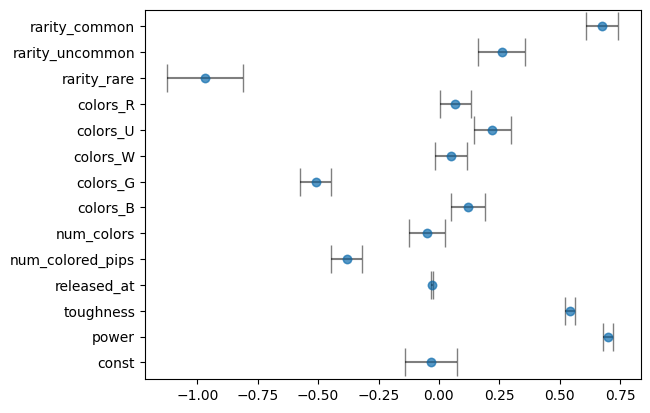

In [20]:
model = sm.OLS(np.asarray(y, dtype=int), np.asarray(X, dtype=int)).fit()
c = []
cn = []
# cn.append("Intercept")
# c.append(reg2.intercept_)
errors = []
standard_errors = model
# print("Intercept:", reg2.intercept_)
for name, coef, err in zip(X.columns, model.params, model.bse):
#     print(f"{name} Coefficient: {coef}")
    c.append(coef)
    cn.append(name)
    errors.append(err)

fig, ax = plt.subplots()
# Create the scatter plot
ax.scatter(c, cn, alpha=0.5)

# Show the plot
# Create the scatter plot with error bars
ax.errorbar(c, cn, xerr=errors, fmt='o', alpha=0.5, ecolor='black', capsize=10)

# Show the plot
plt.show()

In [21]:
aergaerg

NameError: name 'aergaerg' is not defined

In [ ]:
x = set()
for i, row in df.iterrows():
    if row['set'] not in ['afr', '40k', 'clb', 'sld']:
        x = x.union(row['keywords'])
    else:
        # ignore multimodal keywords
        x = x.union([i for i in row['keywords'] if ' ' not in i])
keyword_soup = ' '.join(x).lower()
print(keyword_soup)

In [ ]:
removes = [r'\(.*?\)', r'\{.*?\}', r'—[^ ][^\n]*', r'(P|p)rotection(?! F)[^\n]*', r'\d*', r'Prototype[^\n]*']
#r'—[^{][^T][^\n]*', 
# todo protection, ward, a lot of stuff actually

def extract_ability_text(row):
    text = row['oracle_text']

    if text is np.nan:
        return ''
    
    for r in removes:
        text = re.sub(r, '', text)
    text = text.replace(',', '').replace(';', '')
    text = text.lower()
    text = text.strip()

    return text

def is_french_vanilla(row):
    text = row['oracle_text']
    
    if text == '': 
        return True # is just vanilla
    
    if text is np.nan:
        return False # is not valid
    
    text = extract_ability_text(row)

    for i in text.split():
        if i not in keyword_soup:
            return False

    return True

french_vanilla_df = df[df["type_line"].str.contains("Creature", na=False)] # for now just creatures
french_vanilla_df = french_vanilla_df.sort_values(by=['name'])
french_vanilla_df['is_french_vanilla'] = french_vanilla_df.apply(is_french_vanilla, axis=1)
french_vanilla_df = french_vanilla_df[french_vanilla_df['is_french_vanilla']]

french_vanilla_df = french_vanilla_df.sort_values(by=['name'])

french_vanilla_df


In [ ]:
french_vanilla_df[french_vanilla_df['rarity'] == 'mythic']

In [ ]:
# todo organize code

# ignore type line for now
data_df = french_vanilla_df.drop(columns=['name', 'mana_cost', 'type_line', 'oracle_text', 'color_identity', 'set', 'is_french_vanilla', 'games', 'legalities'])
data_df['cmc'] = data_df['cmc'].apply(int)
data_df['power'] = data_df['power'].apply(int)
data_df['toughness'] = data_df['toughness'].apply(int)
data_df


In [ ]:
def dummy_list(data_df, one_hot_df, column):
    x = set(data_df.explode(column)[column].values)
    x.remove(np.nan)
    
    for i in x:
        one_hot_df[f'{column}_{i}'] = data_df[column].apply(lambda j: j.count(i))
    

one_hot_df = pd.get_dummies(data_df.drop(columns=['colors', 'keywords']))
dummy_list(data_df, one_hot_df, 'colors')
dummy_list(data_df, one_hot_df, 'keywords')
one_hot_df

In [ ]:
# make new dummy matrices for interaction terms
X = one_hot_df.drop(columns=['cmc', 'rarity_common', 'colors_R'])
y = one_hot_df['cmc']

# make new linear regression
reg2 = LinearRegression().fit(X, y)

# print all coefficients
for name, coef in zip(X.columns, reg2.coef_):
    print(f"{name} Coefficient: {coef}")
print("Intercept:", reg2.intercept_)


In [ ]:
activated_abilities_df = df[df["type_line"].str.contains("Creature", na=False)]

def extract_activated_abilities(row):
    text = row['oracle_text']
    
    if text == '': 
        return [] # is just vanilla
    
    if text is np.nan:
        return [] # is not valid
    
    text = re.sub(removes[0], '', text)
    ret = []
    for i in text.split("\n"):
        if ":" in i:
#         if i.lower().split()[0].strip(",;") not in keyword_soup:
            ret.append(i.replace(row['name'], 'CARDNAME'))
    return ret
    
import collections
count = collections.defaultdict(int)
for i, row in activated_abilities_df.iterrows():
    ret = extract_activated_abilities(row)
    for j in ret:
        count[j] += 1

for k, v in count.items():
    if v > 5:
        print(k, v)
